In [1]:
# what to do next time: Use pipeline, change correlation parameter, clean code to put in github,
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.regression.linear_model as sm
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [20]:
# check number of obj and numeric columns of training and test datasets
def dim_check(train, test):
    
    print('Training set dimension: {}'.format(train.shape))
    print('Test set dimension:     {}'.format(test.shape))
    print('-----------------------------------------')
    print('Number of training set object col:  {}'.format(len(train.select_dtypes(include = ['object', 'bool']).columns)))
    print('Number of training set numeric col: {}'.format(len(train.select_dtypes(include = ['float64', 'int64', 'int32']).columns)))
    print('-----------------------------------------')
    print('Number of test set object col:  {}'.format(len(test.select_dtypes(include = ['object', 'bool']).columns)))
    print('Number of test set numeric col: {}'.format(len(test.select_dtypes(include = ['float64', 'int64', 'int32']).columns)))


def del_null_val(dataset):
    # Find null values in Train dataset
    listt = dataset.isnull().sum()
    del_nul_col = listt[listt > 100]
    #print(del_nul_col, '\n\n')

    # Delete columns with null values
    dataset.drop(columns = del_nul_col.index, inplace = True)
    return dataset

df_train = del_null_val(df_train)
df_test = del_null_val(df_test)
print(df_train.shape, df_test.shape)

(1460, 59) (1459, 58)


## Data Preprocessing

#### Explore Object columns

In [4]:
def col_type_list(dataset, col_type_list):
    col_list = dataset.select_dtypes(include = col_type_list).columns
    #print(dataset.select_dtypes(include = col_type_list).shape)
    return col_list
    
col_obj = col_type_list(df_train, ['object', 'bool'])
col_num = col_type_list(df_train, ['float64', 'int64', 'int32'])

# let's exclude all obj columns with missing data in train dataset
def list_obj_null(dataset):
    
    col_obj = col_type_list(dataset, ['object', 'bool'])
    listt = dataset[col_obj].isnull().sum()
    del_serie = listt[listt > 0]
    #print(del_serie, '\n\n')
    
    return del_serie

# fill nan values of object features with top frequent values, only frequent values that are less than 85 % of total 
# numbers
def fill_nan_obj(series, dataset):
    # Select features with nan values of less than 5
    for i in series.index:
        if series[i] < 45:
            if dataset[i].describe().freq < dataset.shape[0] * 0.85:
                dataset[i].fillna(dataset[i].describe().top, inplace = True)
    
    list_ = dataset[col_obj].isnull().sum()
    check_list = list_[list_ > 0]
    print(check_list, '\n\n')
    
    return dataset
        

df_train = fill_nan_obj(list_obj_null(df_train), df_train)
df_test = fill_nan_obj(list_obj_null(df_test), df_test) 
dim_check()

BsmtCond        37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64 


Utilities        2
BsmtCond        45
Functional       2
GarageType      76
GarageFinish    78
GarageQual      78
GarageCond      78
SaleType         1
dtype: int64 


Training set dimension: (1460, 75)
Test set dimension:     (1459, 74)
-----------------------------------------
Number of training set object col:  38
Number of training set numeric col: 37
-----------------------------------------
Number of test set object col:  38
Number of test set numeric col: 36


In [5]:
# All object columns with missing value in both training and test sets must be deleted from both datasets
list_to_del = list(list_obj_null(df_train).index | list_obj_null(df_test).index)
list_to_del

['BsmtCond',
 'BsmtFinType2',
 'Electrical',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'SaleType',
 'Utilities']

In [6]:
# Delete columns with any null OBJECT values 
df_train.drop(columns = list_to_del, inplace = True)
df_test.drop(columns = list_to_del, inplace = True)
dim_check()

Training set dimension: (1460, 65)
Test set dimension:     (1459, 64)
-----------------------------------------
Number of training set object col:  28
Number of training set numeric col: 37
-----------------------------------------
Number of test set object col:  28
Number of test set numeric col: 36


In [7]:
# Object columns:
col_obj = col_type_list(df_train, ['object', 'bool'])
# Object columns:
col_obj_test = col_type_list(df_test, ['object', 'bool'])

In [8]:
# Visualize categorical features in train dataset
# with no null value
def plot_subplot(dataset, feat_type):
    
    %matplotlib notebook
    col_obj = col_type_list(dataset, feat_type)
    n = len(col_obj)
    plt.figure(figsize=(10, 6))
    labels = col_obj[:n]
    for i in range(n):
        plt.subplot(np.sqrt(n), np.sqrt(n)+1, i +1)
        plt.scatter(dataset[col_obj[i]], dataset['SalePrice'], label = 'Real Price', s = 4)
        plt.xlabel(col_obj[i])
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


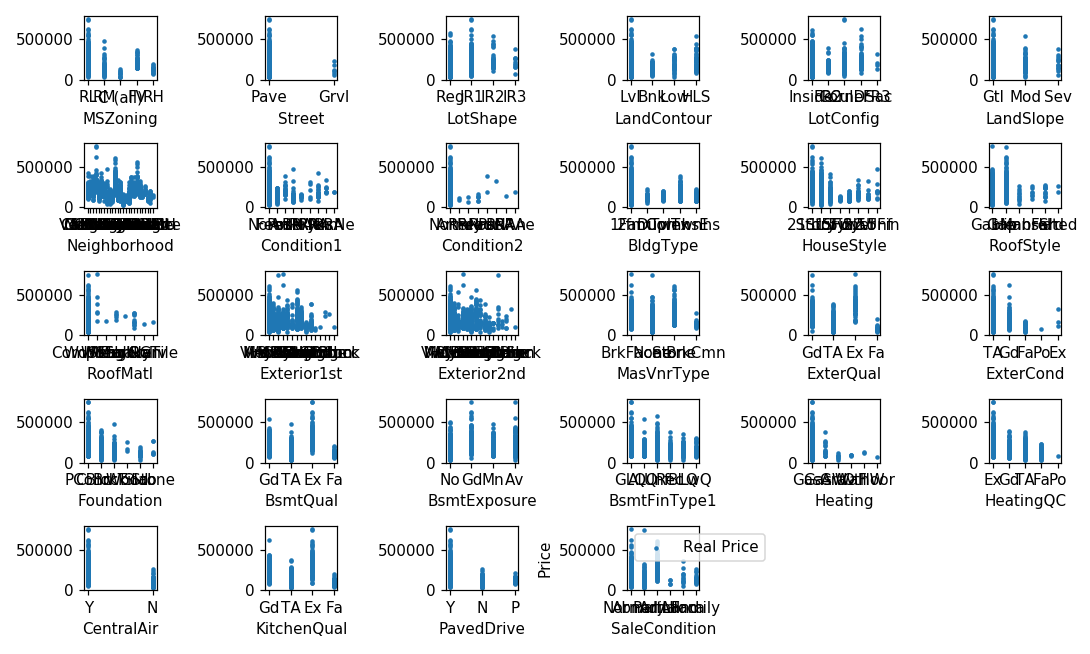

In [9]:
plot_subplot(df_train, ['object', 'bool'])

#### Autoencoder for categorical feature of N variables

In [10]:
# Find categorical features with N vaiable in training dataset
def cat_uniq_list(dataset, label, N):
    
    column_obj = col_type_list(dataset, ['object', 'bool'])
    cat_uniq = dataset[column_obj].nunique()
    name = 'cat_{}_feat_'.format(N) + label
    uniq_list = cat_uniq[cat_uniq == N].index
    return{name: uniq_list}

dic = {}        
for i in range(2, 9, 1):       
    dic.update(cat_uniq_list(df_train, 'train', i))
    dic.update(cat_uniq_list(df_test, 'test', i))
dic

{'cat_2_feat_train': Index(['Street', 'CentralAir'], dtype='object'),
 'cat_2_feat_test': Index(['Street', 'CentralAir'], dtype='object'),
 'cat_3_feat_train': Index(['LandSlope', 'PavedDrive'], dtype='object'),
 'cat_3_feat_test': Index(['LandSlope', 'PavedDrive'], dtype='object'),
 'cat_4_feat_train': Index(['LotShape', 'LandContour', 'MasVnrType', 'ExterQual', 'BsmtQual',
        'BsmtExposure', 'KitchenQual'],
       dtype='object'),
 'cat_4_feat_test': Index(['LotShape', 'LandContour', 'RoofMatl', 'MasVnrType', 'ExterQual',
        'BsmtQual', 'BsmtExposure', 'Heating', 'KitchenQual'],
       dtype='object'),
 'cat_5_feat_train': Index(['MSZoning', 'LotConfig', 'BldgType', 'ExterCond', 'HeatingQC'], dtype='object'),
 'cat_5_feat_test': Index(['MSZoning', 'LotConfig', 'Condition2', 'BldgType', 'ExterCond',
        'HeatingQC'],
       dtype='object'),
 'cat_6_feat_train': Index(['RoofStyle', 'Foundation', 'BsmtFinType1', 'Heating', 'SaleCondition'], dtype='object'),
 'cat_6_feat_te

In [11]:
# Compare number of variables in training and test datasets for each feature
ddic = {}
def var_check():
    for dataset, label in zip([df_train, df_test], ['train', 'test']):
        column_obj = col_type_list(dataset, ['object', 'bool'])
        cat_uniq = dataset[column_obj].nunique()
        name = 'cat_uniq_' + label
        ddic.update({name: cat_uniq})

    df_compare = pd.DataFrame({'Train': ddic['cat_uniq_train'], 'Test': ddic['cat_uniq_test']})
    df_compare['train - test'] = df_compare['Train'] - df_compare['Test']
    df_compare[df_compare['train - test']>=0].sort_values(by = 'train - test', ascending = False)
    
    return df_compare
dfff = var_check()
dfff

,Train,Test,train - test
MSZoning,5,5,0
Street,2,2,0
LotShape,4,4,0
LandContour,4,4,0
LotConfig,5,5,0
LandSlope,3,3,0
Neighborhood,25,25,0
Condition1,9,9,0
Condition2,8,5,3
BldgType,5,5,0


In [12]:
# Delete those object columns in training and test sets with different number of variables
del_diff_var = dfff[dfff['train - test'] > 0].index
del_diff_var

Index(['Condition2', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'Heating'],
      dtype='object')

In [13]:
# Delete columns with any different number of features
df_train.drop(columns = del_diff_var, inplace = True)
df_test.drop(columns = del_diff_var, inplace = True)
print(df_train.shape, df_test.shape)

(1460, 59) (1459, 58)


In [14]:
dic = {}        
for i in range(2, 9, 1):       
    dic.update(cat_uniq_list(df_train, 'train', i))
    dic.update(cat_uniq_list(df_test, 'test', i))
var_check().sort_values(by = 'Train')

,Train,Test,train - test
Street,2,2,0
CentralAir,2,2,0
LandSlope,3,3,0
PavedDrive,3,3,0
MasVnrType,4,4,0
LotShape,4,4,0
LandContour,4,4,0
KitchenQual,4,4,0
BsmtExposure,4,4,0
BsmtQual,4,4,0


In [15]:
# Encode features with two variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_X_2 = LabelEncoder()

In [16]:
df_train[dic['cat_2_feat_train']].head()

,Street,CentralAir
0,Pave,Y
1,Pave,Y
2,Pave,Y
3,Pave,Y
4,Pave,Y


In [17]:
#Atuencoding for 2-variable categorical features in training dataset
for i in dic['cat_2_feat_train']:
    df_train[i] = labelencoder_X_2.fit_transform(df_train[i])
df_train[dic['cat_2_feat_train']].head()

,Street,CentralAir
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [18]:
#Atuencoding for 2-variable categorical features in training dataset
for i in dic['cat_2_feat_test']:
    df_test[i] = labelencoder_X_2.fit_transform(df_test[i])
df_test[dic['cat_2_feat_test']].head()

,Street,CentralAir
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [21]:
# Check that number of obj columns is reduced by 2
dim_check(df_train, df_test)

Training set dimension: (1460, 59)
Test set dimension:     (1459, 58)
-----------------------------------------
Number of training set object col:  20
Number of training set numeric col: 39
-----------------------------------------
Number of test set object col:  20
Number of test set numeric col: 38


In [22]:
# Define a function to encode  categorical features with more than 2 variables
def encode_features(cat_feature, N, dataset):
    n = len(cat_feature)
    x = dataset[cat_feature]
    k = 0
    col_name = []
    for i in range(n):
        columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [i + k])], remainder='passthrough') 
        x = np.array(columnTransformer.fit_transform(x), dtype = np.str)
        # Avoid dummy variable trap:
        x = x[:, 1:]
        k = (N - 2) * (i + 1)
        for j in range(1, N, 1):
            col_name.append(cat_feature[i] + '_' + str(N) + '_' + str(j))
        
    df = pd.DataFrame(x, columns = col_name, index = dataset.index)
    return df

In [23]:
dataset = df_train.copy()
print(dataset.shape)
df3 = encode_features(dic['cat_3_feat_train'], 3, dataset)
df4 = encode_features(dic['cat_4_feat_train'], 4, dataset)
df5 = encode_features(dic['cat_5_feat_train'], 5, dataset)
df6 = encode_features(dic['cat_6_feat_train'], 6, dataset)

df_encoded_train =  pd.concat([df3, df4, df5, df6], axis=1)
print(df_encoded_train.shape) 

(1460, 59)
(1460, 65)


In [24]:
dataset = df_test.copy()
print(dataset.shape)
df3 = encode_features(dic['cat_3_feat_test'], 3, dataset)
df4 = encode_features(dic['cat_4_feat_test'], 4, dataset)
df5 = encode_features(dic['cat_5_feat_test'], 5, dataset)
df6 = encode_features(dic['cat_6_feat_test'], 6, dataset)

df_encoded_test =  pd.concat([df3, df4, df5, df6], axis=1)
print(df_encoded_test.shape) 

(1459, 58)
(1459, 65)


#### Explore Numeric features

In [25]:
# Return list of features with more than 5 % correlation to SalePrice
def correlated_features():
    
    df_train_num = df_train.select_dtypes(include = ['float64', 'int64'])
    df_test_num = df_test.select_dtypes(include = ['float64', 'int64'])
    
    df_train_corr = df_train_num.corr()
    corr_filtered =  df_train_corr[np.abs(df_train_corr['SalePrice']) > 0.05]
    print('Size of correlation matrix: {}'.format(corr_filtered.shape))
    
    return [corr_filtered, df_train_corr, df_train_num, df_test_num]

corr_filtered = correlated_features()[0]

Size of correlation matrix: (29, 37)


In [26]:
# Plot correlation matrix in a heat map
show_corr  = False
if show_corr == True:
    %matplotlib notebook
    fig = plt.figure(figsize=(10, 10))
    dataset = correlated_features()[1]
    mask = np.triu(np.ones_like(dataset, dtype=np.bool))
    sns_plot = sns.heatmap(dataset, annot=False, mask = mask)
    fig = sns_plot.get_figure()
    fig.savefig('correlation.png', dip = 500)

In [27]:
col = corr_filtered.index
col

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'SalePrice'],
      dtype='object')

In [28]:
df_train_num_high_corr = correlated_features()[2][col]
df_train_num_high_corr.shape

Size of correlation matrix: (29, 37)


(1460, 29)

Find Nan values in dataset

In [29]:
# find nan values in train dataset
a = df_train_num_high_corr.isnull().sum()
a[a > 0].index


Index(['MasVnrArea', 'GarageYrBlt'], dtype='object')

In [30]:
def fill_nan(dataset):
    serie_nan = dataset.isnull().sum()
    print(serie_nan[serie_nan > 0])
    list_nan_index = serie_nan[serie_nan > 0].index
    
    for i in list_nan_index:
        dataset[i].fillna(dataset[i].mean(), inplace = True)

    
fill_nan(df_train_num_high_corr)

MasVnrArea      8
GarageYrBlt    81
dtype: int64


In [31]:
y = df_train_num_high_corr['SalePrice']
x_frame = df_train_num_high_corr[col[:-1]]
x = df_train_num_high_corr[col[:-1]].values
x.shape

(1460, 28)

### Backward elimination with p-value only

In [62]:
# Extract important features of numerical features using p-value
import statsmodels.regression.linear_model as sm
def backwardElimination_p(x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit() 
        maxVar = max(regressor_OLS.pvalues)#.astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    
    print(regressor_OLS.summary())
    return x
     
# Extract important features of numerical features using p-value and adjusted-R
def backwardElimination_p_R(x, SL):
    numVars = len(x[0])
    temp = np.zeros((1460,25)).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)#.astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x    
    

SL = 0.05
#X_opt = X[:, [0, 1, 2, 3, 4, 5]]
X_Modeled = backwardElimination_p(x, SL)

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              2316.
Date:                Tue, 19 May 2020   Prob (F-statistic):                        0.00
Time:                        07:18:18   Log-Likelihood:                         -17356.
No. Observations:                1460   AIC:                                  3.475e+04
Df Residuals:                    1441   BIC:                                  3.485e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
np.isin(x[0, :], X_Modeled[0, :])
index_imp = np.argwhere(np.isin(x[0, :], X_Modeled[0, :]) == True) # Index of important features
index_imp
Important_features = [col[i][0] for i in index_imp]
Important_features

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'WoodDeckSF',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea']

### Join object and numeric features

In [35]:
# Add encoded categorical features to the numerical features
df_train_final = pd.concat([df_train_num_high_corr[Important_features], df_encoded_train], axis=1)
print(df_train_final.shape, df_encoded_train.shape, df_train_num_high_corr[Important_features].shape)
list1 = df_encoded_train.index.tolist()
list2 = df_train_num_high_corr[Important_features].index.tolist()
for i in np.isin(list1, list2):
    if i == False:
        print(i)

(1460, 89) (1460, 65) (1460, 24)


In [63]:
y_opt = df_train['SalePrice']
x_opt = df_train_final.iloc[:, :].values# remove saleprice from the list
print(y_opt.shape, x_opt.shape)

(1460,) (1460, 89)


### Prepare test dataset

In [53]:
# Just consider numeric columns with important features as we obtained using OLS
df_test_num = df_test[Important_features]

In [54]:
fill_nan(df_test_num)

MasVnrArea      15
BsmtFinSF1       1
TotalBsmtSF      1
BsmtFullBath     2
GarageYrBlt     78
GarageCars       1
dtype: int64


C:\Users\u0125384\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [64]:
df_test_final = pd.concat([df_test_num, df_encoded_test], axis=1)
x_submission = df_test_final.values
print(x_submission.shape,df_encoded_test.shape, df_test_num.shape)

(1459, 89) (1459, 65) (1459, 24)


In [65]:
dim_check(df_train_final, df_test_final)
x_submission

Training set dimension: (1460, 89)
Test set dimension:     (1459, 89)
-----------------------------------------
Number of training set object col:  65
Number of training set numeric col: 24
-----------------------------------------
Number of test set object col:  65
Number of test set numeric col: 24


array([[20, 11622, 5, ..., '0.0', '0.0', '0.0'],
       [20, 14267, 6, ..., '1.0', '0.0', '0.0'],
       [60, 13830, 5, ..., '0.0', '0.0', '0.0'],
       ...,
       [20, 20000, 5, ..., '0.0', '0.0', '0.0'],
       [85, 10441, 5, ..., '0.0', '0.0', '0.0'],
       [60, 9627, 7, ..., '0.0', '0.0', '0.0']], dtype=object)

In [119]:
# Prepare the submission file
def prepare_submission(model, x, file_name):
      
    # Predict saleprice for test dataset
    y_prediction = model.predict(x)
    # Prepare submission file
    submission = pd.DataFrame({'Id': df_test['Id'].tolist(), 'SalePrice': y_prediction})
    submission.to_csv(file_name, index = False)
    
def select_type(df, data_type):
    if data_type == 'numeric':
        return df.select_dtypes(include = ['float64', 'int64', 'int32'])
    elif data_type == 'obj':
        return df.select_dtypes(include = ['object', 'bool'])
    elif data_type == 'all':
        return df

### Grid Search

In [113]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [120]:
y_opt = df_train['SalePrice']
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

In [67]:
model = GradientBoostingRegressor()
parameters = {'learning_rate': [0.018, 0.02, 0.022],
                  'subsample'    : [0.9, 0.8, 0.7],
                  'n_estimators' : [500, 800, 1000],
                  'max_depth'    : [4, 5, 6],
              'min_samples_split': [2, 3]
                 }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 10, n_jobs=-1)
grid.fit(x_opt, y_opt)    

    # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.018, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.65, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.8859072305035374

 The best parameters across ALL searched params:
 {'learning_rate': 0.018, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 800, 'subsample': 0.65}


In [68]:
accuracies = cross_val_score(estimator=model, X = x_opt, y = y_opt, cv = 10)
print(accuracies)
print(accuracies.mean())

[0.87493035 0.89304526 0.92030817 0.72593854 0.91018483 0.88877434
 0.85488163 0.88402928 0.9050964  0.87798697]
0.8735175768356311


In [114]:
model_grid_search = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.022, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
model_grid_search.fit(x_opt, y_opt)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.022, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
# The best parameters so far are:
"""alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
init=None, learning_rate=0.022, loss='ls',
max_depth=4, max_features=None, max_leaf_nodes=None,
min_impurity_decrease=0.0, min_impurity_split=None,
min_samples_leaf=1, min_samples_split=2,
min_weight_fraction_leaf=0.0, n_estimators=800,
n_iter_no_change=None, presort='deprecated',
random_state=None, subsample=0.75, tol=0.0001,
validation_fraction=0.1, verbose=0, warm_start=False"""

# With best score so far 0.9883688838026587 (score on kaggle: 14703.63420)

"alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',\ninit=None, learning_rate=0.022, loss='ls',\nmax_depth=4, max_features=None, max_leaf_nodes=None,\nmin_impurity_decrease=0.0, min_impurity_split=None,\nmin_samples_leaf=1, min_samples_split=2,\nmin_weight_fraction_leaf=0.0, n_estimators=800,\nn_iter_no_change=None, presort='deprecated',\nrandom_state=None, subsample=0.75, tol=0.0001,\nvalidation_fraction=0.1, verbose=0, warm_start=False"

In [115]:
model_grid_search.score(x_opt, y_opt) # best score so far 0.9883688838026587

0.9882363969989875

In [117]:
prepare_submission(model_grid_search, x_submission,'submission_XGB_grid_search.csv')

### Linear Regression

In [121]:
# Linear Model
y_opt = df_train['SalePrice']
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt, test_size = 0.25, random_state = 0)

# Create a Linear regression model
LR = LinearRegression()
LR.fit(x_train_opt, y_train_opt)

print('Training score: {}'.format(LR.score(x_train_opt, y_train_opt)))
print('Test score {}'.format(LR.score(x_test_opt, y_test_opt)))

#y_prediction_submission = LR.predict(x_submission)
prepare_submission(LR, x_submission, 'Linear_Regression.csv')

Training score: 0.8864973741821528
Test score 0.7361545729748205


### Polynomial Regression

In [123]:
from sklearn.preprocessing import PolynomialFeatures

y_opt = df_train['SalePrice']
data_type = 'numeric'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values


# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt, test_size = 0.25, random_state = 0)

poly_reg = PolynomialFeatures(degree=2)
x_poly_train = poly_reg.fit_transform(x_train_opt)
x_poly_test = poly_reg.fit_transform(x_test_opt)
LR = LinearRegression()
LR.fit(x_poly_train, y_train_opt)

print('Training score: {}'.format(LR.score(x_poly_train, y_train_opt)))
print('Test score {}'.format(LR.score(x_poly_test, y_test_opt)))

x_submission = poly_reg.fit_transform(x_submission)
prepare_submission(LR, x_submission, 'Polynomial_Regression.csv')

Training score: 0.9071534009668795
Test score 0.0964243138175801


### Support Vector Regressor

In [124]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
model = SVR(kernel='rbf', gamma='auto') # this used for nonlinear

In [125]:
y_opt_array = df_train['SalePrice'].values
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt_array, 
                                                                    test_size = 0.25, 
                                                                    random_state = 0)

#Feature scaling
SC = StandardScaler()
x_train_sc = SC.fit_transform(x_train_opt)
x_test_sc = SC.fit_transform(x_test_opt)
x_sc_submission = SC.fit_transform(x_submission)
x

SC = StandardScaler()
y_train_sc = SC.fit_transform(y_train_opt.reshape(-1, 1))
y_test_sc = SC.fit_transform(y_test_opt.reshape(-1, 1))

In [126]:
# Fitting SVM to dataset
model.fit(x_train_sc, y_train_sc)

C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [127]:
# Model score on training and test dataset
print('Training score: {}'.format(model.score(x_train_sc, y_train_sc)))
print('Test score {}'.format(model.score(x_test_sc, y_test_sc)))

prepare_submission(model, x_sc_submission,'Support_vector_machine.csv')

Training score: 0.9283653401935283
Test score 0.7535185765745641


### Decision Tree Regressor

In [128]:
# Import library
from sklearn.tree import DecisionTreeRegressor

In [135]:
y_opt = df_train['SalePrice']
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt_array, 
                                                                    test_size = 0.25, 
                                                                    random_state = 0)

In [136]:
#Fitting the decision tree regressor to training dataset
model = DecisionTreeRegressor(random_state=0)
model.fit(x_train_opt, y_train_opt)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [137]:
# Model score on training and test dataset
print('Training score: {}'.format(model.score(x_train_opt, y_train_opt)))
print('Test score {}'.format(model.score(x_test_opt, y_test_opt)))

prepare_submission(model, x_submission,'Decision_Tree_Regressor.csv')

Training score: 0.9999958627883332
Test score 0.745535714977164


### Random Forest Regression

In [140]:
# Import library
from sklearn.ensemble import RandomForestRegressor

In [141]:
# Prepare x and y data
y_opt = df_train['SalePrice']
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt_array, 
                                                                    test_size = 0.25, 
                                                                    random_state = 0)

In [142]:
# Fitting random forest regression to training dataset
model = RandomForestRegressor(n_estimators = 300,random_state=0)
model.fit(x_train_opt, y_train_opt)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [143]:
# Model score on training and test dataset
print('Training score: {}'.format(model.score(x_train_opt, y_train_opt)))
print('Test score {}'.format(model.score(x_test_opt, y_test_opt)))

prepare_submission(model, x_submission,'Random_Forest_Regressor.csv')

Training score: 0.9786727682341876
Test score 0.8570554504307586


### XGBoost

In [146]:
# Import library
import xgboost as xgb

In [147]:
# Prepare x and y data
y_opt = df_train['SalePrice']
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values

# Split train data into train and test
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(x_opt, y_opt_array, 
                                                                    test_size = 0.25, 
                                                                    random_state = 0)

In [149]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
model.fit(x_train_opt, y_train_opt)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method=None, validate_parameters=False, verbosity=None)

In [150]:
# Model score on training and test dataset
print('Training score: {}'.format(model.score(x_train_opt, y_train_opt)))
print('Test score {}'.format(model.score(x_test_opt, y_test_opt)))

prepare_submission(model, x_submission,'XGBoost.csv')

Training score: 0.9999943914292758
Test score 0.8924277360048862


### Apply k-fold cross validation

In [151]:
from sklearn.model_selection import cross_val_score

In [152]:
y_opt_array = df_train['SalePrice'].values
data_type = 'all'
x_opt = select_type(df_train_final, data_type).iloc[:, :].values# remove saleprice from the list
x_submission = select_type(df_test_final, data_type).values



#Feature scaling
SC = StandardScaler()
x_sc = SC.fit_transform(x_opt)
x_sc_submission = SC.fit_transform(x_submission)

SC = StandardScaler()
y_sc = SC.fit_transform(y_opt_array.reshape(-1, 1))


In [127]:
#Feature scaling
y_opt_array = df_train['SalePrice'].values
SC = StandardScaler()
x_sc = SC.fit_transform(x_opt)
x_sc_submission = SC.fit_transform(x_submission)
SC = StandardScaler()
y_sc = SC.fit_transform(y_opt_array.reshape(-1, 1))

In [153]:
model = SVR(kernel = 'rbf', gamma = 'auto')
model.fit(x_sc, y_sc)

C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [155]:
accuracies = cross_val_score(estimator=model, X = x_sc, y = y_sc, cv = 10)

C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0125384\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [158]:
accuracies

array([0.830424  , 0.82359769, 0.84531896, 0.7901982 , 0.79795852,
       0.81663656, 0.90386103, 0.88438071, 0.61658594, 0.83321238])

In [157]:
prepare_submission(model, x_sc_submission,'SVR_with_k_fold_cross_validation.csv')